# Determining the optimal RF cut

In [1]:
run prep_ana.py

loading data frame named df.
finished loading data frame
unc_mc_process and scales are dictionaries
scale_data = (5.27/19.7)


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [83]:
import pandas as pd

In [2]:
bins_rf = {}
for process in scales.keys():
    if "WJ" in process:
        continue
    bins_rf[process] = list(np.histogram(df[(df[process]==1) ].rf_result , bins=10000, range=(-1.01,1.01)))
    bins_rf[process][0] = np.array(bins_rf[process][0] * scales[process])

In [5]:
def integral(data):
    x = []
    for i in xrange(len(data)):
        x.append(data[i:].sum())
    return np.array(x)

In [6]:
integral_rf = {}
for process in bins_rf.keys():
    integral_rf[process]= integral(bins_rf[process][0])

## Uncertainty procedure

stat and norm were described in updated_cuts.pdf

calc_stat_unc

$\large{\frac{1}{L*eff*acc}\sqrt{\sum{(scaling_{process} * \sqrt{N_{process}})^2}}} $ 

calc_norm_unc 

$\large{\frac{1}{L*eff*acc}\sqrt{\sum{(unc_{process} * N_{process})^2}}} $ 


calc_acc_unc

Both stat and norm are determined from the background.  They are also quantities which are derived from the numerator of the cross-section formula. Both of these terms fall as we tighten the random forest cut. This is intuitive and easily shown given the sentence above. The acc, acceptance, uncertainty must increase as we tighten are cut as reducing the acceptance would increase the cross-section value. 

$\large{ \frac{1}{L*eff} \sqrt{(\frac{D-BG}{acc})^2 * (\frac{scaling_{WW} * \sqrt{N_{WW}}}{N_{tot WW}})^2}}$

where $acc=N_{WW} / N_{totWW}$


In [10]:
def calc_norm_unc( data ):
    coeff = 1./(19.4e3*.15*(3*.108)**2*(data["WW"] /  data["WW"][0]))
    norm = [ unc_mc_process[process]*(data[process])**0.5 for process in data.keys() if "WW" not in process]
    sum_norm = np.zeros(len(data[process]))
    for ele in norm:
        sum_norm += ele**2
    return coeff*sum_norm**.5

In [7]:
def calc_stat_unc( data ):
    coeff = 1./(19.4e3*.15*(3*.108)**2*(data["WW"] /  data["WW"][0]))
    norm = [ scales[process]*(data[process]/scales[process])**0.5 for process in data.keys() if "WW" not in process]
    sum_norm = np.zeros(len(data[process]))
    for ele in norm:
        sum_norm += ele**2
    return coeff*sum_norm**.5

In [254]:
def calc_acc_unc( data ):
    coeff = 1./(19.4e3*.15*(3*.108)**2)
    acc = (data["WW"]/  data["WW"][0])
    tot = [ data[process] for process in data.keys() ]
    bg = [ data[process] for process in data.keys() if "WW" not in process]
    
    
    sum_tot = np.zeros(len(data[process]))
    sum_bg = np.zeros(len(data[process]))
    for iter in xrange(len(tot)):
        sum_tot += tot[iter]
    for iter in xrange(len(bg)):
        sum_bg += bg[iter]
        
    acc_unc = ( ( sum_tot - sum_bg ) / acc**2 )**2 * (scales["WW"] * (data["WW"] / scales["WW"])**.5/data["WW"][0])**2
    return coeff*acc_unc**.5

In [8]:
def full_stat( data ):
    coeff = 1./(19.4e3*.15*(3*.108)**2*(data["WW"] /  data["WW"][0]))
    stat = np.zeros(len(data["WW"]))
    for i in data.keys():
        stat += data[i]
        
    return coeff*(stat)**.5

In [11]:
unc_sum = np.power(calc_norm_unc( integral_rf )**2 + calc_stat_unc( integral_rf )**2 + full_stat( integral_rf),.5)#calc_acc_unc( integral_rf)**2  , .5)

## Results 

In [12]:
print "bin with min cut",unc_sum[np.isfinite(unc_sum)].argmin()
print "uncertainty at cut",unc_sum[9944]
print "rf value at cut", bins_rf["WW"][1][9944]

bin with min cut 9944
uncertainty at cut 1.0829838557
rf value at cut 0.998688


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

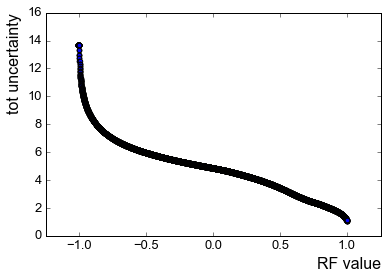

In [14]:
fig , ax = plt.subplots()
ax.scatter( bins_rf["WW"][1][:-1], unc_sum)
ax.set_xlim((-1.25, 1.25))
ax.set_ylim(bottom=0)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)
ax.set_xlabel("RF value", horizontalalignment='right', position=(1., 0.), va='bottom', ha='right', fontsize=16, fontname='Arial')
ax.set_ylabel("tot uncertainty", position=(-0.5, 1.), va='top', ha='right', fontsize=16, fontname='Arial')
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
#ax.get_xaxis().tick_bottom()
#ax.get_yaxis().tick_left()

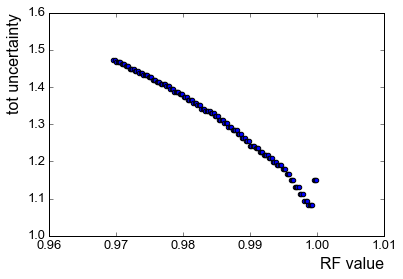

In [15]:
fig , ax = plt.subplots()
ax.scatter( bins_rf["WW"][1][-201:-1], unc_sum[-200:])
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)
ax.set_xlabel("RF value", horizontalalignment='right', position=(1., 0.), va='bottom', ha='right', fontsize=16, fontname='Arial')
ax.set_ylabel("tot uncertainty", position=(-0.5, 1.), va='top', ha='right', fontsize=16, fontname='Arial')
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20